In [1]:
import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import glob
import random
import cv2
import numpy as np
import torch
import torch.nn.functional as F

from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.dependency.track_predict import predict_tracks
from vggt.dependency.np_to_pycolmap import batch_np_matrix_to_pycolmap, batch_np_matrix_to_pycolmap_wo_track

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def run_VGGT(model, images, dtype, resolution=518):
    # images: [B, 3, H, W]

    assert len(images.shape) == 4
    assert images.shape[1] == 3

    # hard-coded to use 518 for VGGT
    images = F.interpolate(images, size=(resolution, resolution), mode="bilinear", align_corners=False)
    images = images.to(next(model.parameters()).device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            aggregated_tokens_list, ps_idx = model.aggregator(images)

        # Predict Cameras
        pose_enc = model.camera_head(aggregated_tokens_list)[-1]
        # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])
        # Predict Depth Maps
        depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    extrinsic = extrinsic.squeeze(0).cpu().numpy()
    intrinsic = intrinsic.squeeze(0).cpu().numpy()
    depth_map = depth_map.squeeze(0).cpu().numpy()
    depth_conf = depth_conf.squeeze(0).cpu().numpy()
    return extrinsic, intrinsic, depth_map, depth_conf

In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [4]:
# Get image paths and preprocess them
scene_dir = "../data/test"
total_frame_num = 125
image_dir = os.path.join(scene_dir, "images")
image_path_list = sorted(glob.glob(os.path.join(image_dir, "*")))
if len(image_path_list) == 0:
    raise ValueError(f"No images found in {image_dir}")
base_image_path_list = [os.path.basename(path) for path in image_path_list]
if total_frame_num is not None:
    image_path_list = image_path_list[:total_frame_num]
    base_image_path_list = base_image_path_list[:total_frame_num]

vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_square(image_path_list, vggt_fixed_resolution)

In [5]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
extrinsic, intrinsic, depth_map, depth_conf = run_VGGT(model, images, dtype, vggt_fixed_resolution)
points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)

OutOfMemoryError: CUDA out of memory. Tried to allocate 672.00 MiB. GPU 

In [ ]:
import utils.colmap as colmap_utils

sparse_dir_gt = "../data/GauU_Scene/SMBU/sparse/0"
images_dir = "../data/GauU_Scene/SMBU/images"

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))

image_names = [os.path.basename(path) for path in image_path_list]
images_gt_map = {image.name: image for image in list(images_gt.values()) if image.name in image_names}
images_gt_updated = {}
for image_name in list(image_names):
    images_gt_updated[images_gt_map[image_name].id] = images_gt_map[image_name]

In [ ]:
from utils.metric_torch import camera_to_rel_deg, calculate_auc_np

fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3, gt_se3, device, 4)
print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

rError = rel_rangle_deg.cpu().numpy()
tError = rel_tangle_deg.cpu().numpy()

Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
print(f"    --  AUC at 30: {Auc_30:.4f}")

    --  Pair Rot   Error (Deg) of Vanilla:       8.43
    --  Pair Trans Error (Deg) of Vanilla:      23.72
    --  AUC at 30: 0.5883


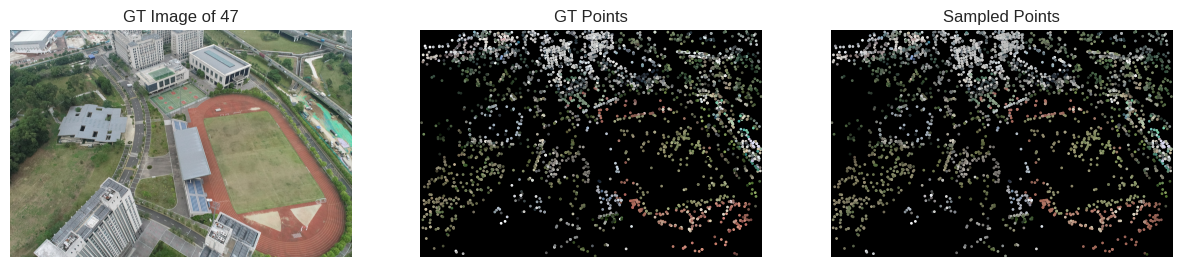

In [ ]:
ANALYZE_PROJECTION = True

if ANALYZE_PROJECTION:

    k = random.choice(list(images_gt_updated.keys()))
    idx = list(images_gt_updated.keys())[k]

    point3D_ids_gt = images_gt_updated[idx].point3D_ids
    mask_gt = point3D_ids_gt >= 0
    xys_gt = images_gt_updated[idx].xys[mask_gt]
    pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)
    pcd_xyz_gt = np.stack([pcd_gt[id].xyz for id in point3D_ids_gt[mask_gt]], axis=0)

    # transform xys_gt to the coordinate on points_3d, which is (N, H, W, 3)
    xys_gt_scaled = np.zeros_like(xys_gt)
    pcd_xyz_sampled = np.zeros_like(pcd_xyz_gt)
    pcd_conf_sampled = np.zeros_like(pcd_rgb_gt[:, 0])  # Assuming confidence is a single channel
    pcd_rgb_sampled = np.zeros_like(pcd_rgb_gt)
    resize_ratio = original_coords[:, -2:].max() / vggt_fixed_resolution

    xys_gt_scaled[:, 0] = xys_gt[:, 0] / resize_ratio + original_coords[k, 0]
    xys_gt_scaled[:, 1] = xys_gt[:, 1] / resize_ratio + original_coords[k, 1]
    pcd_xyz_sampled = points_3d[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_conf_sampled = depth_conf[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_rgb_sampled = images[k, :, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)].permute(1, 0).cpu().numpy() * 255



    image = cv2.imread(os.path.join(images_dir, images_gt_updated[idx].name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_project = np.zeros_like(image)

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"GT Image of {images_gt_updated[idx].id}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image_project)
    plt.scatter(xys_gt[:, 0], xys_gt[:, 1], c=pcd_rgb_gt / 255.0, s=1)
    plt.title("GT Points")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_project)
    plt.scatter(xys_gt[:, 0], xys_gt[:, 1], c=pcd_rgb_sampled / 255.0, s=1)
    plt.title("Sampled Points")
    plt.axis('off')

In [ ]:
from utils.umeyama import umeyama

pcd_xyz_gt_list = []
pcd_rgb_gt_list = []
pcd_xyz_sampled_list = []
pcd_rgb_sampled_list = []
conf_thresh = 0.5  # Confidence threshold for depth map

for k, idx in tqdm(enumerate(list(images_gt_updated.keys()))):

    point3D_ids_gt = images_gt_updated[idx].point3D_ids
    mask_gt = point3D_ids_gt >= 0
    xys_gt = images_gt_updated[idx].xys[mask_gt]
    pcd_rgb_gt = np.stack([pcd_gt[id].rgb for id in point3D_ids_gt[mask_gt]], axis=0)
    pcd_xyz_gt = np.stack([pcd_gt[id].xyz for id in point3D_ids_gt[mask_gt]], axis=0)

    # transform xys_gt to the coordinate on points_3d, which is (N, H, W, 3)
    xys_gt_scaled = np.zeros_like(xys_gt)
    pcd_xyz_sampled = np.zeros_like(pcd_xyz_gt)
    pcd_conf_sampled = np.zeros_like(pcd_rgb_gt[:, 0])  # Assuming confidence is a single channel
    pcd_rgb_sampled = np.zeros_like(pcd_rgb_gt)
    resize_ratio = original_coords[:, -2:].max() / vggt_fixed_resolution

    xys_gt_scaled[:, 0] = xys_gt[:, 0] / resize_ratio + original_coords[k, 0]
    xys_gt_scaled[:, 1] = xys_gt[:, 1] / resize_ratio + original_coords[k, 1]
    pcd_xyz_sampled = points_3d[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_conf_sampled = depth_conf[k, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)]
    pcd_rgb_sampled = images[k, :, xys_gt_scaled[:, 1].astype(int), xys_gt_scaled[:, 0].astype(int)].permute(1, 0).cpu().numpy() * 255

    conf_mask = pcd_conf_sampled > conf_thresh

    pcd_xyz_gt_list.append(pcd_xyz_gt[conf_mask])
    pcd_xyz_sampled_list.append(pcd_xyz_sampled[conf_mask])
    pcd_rgb_gt_list.append(pcd_rgb_gt[conf_mask])
    pcd_rgb_sampled_list.append(pcd_rgb_sampled[conf_mask])

c, R, t = umeyama(np.concatenate(pcd_xyz_gt_list, axis=0).T, np.concatenate(pcd_xyz_sampled_list, axis=0).T)

print("Estimated Camera Parameters:")
print(f"Scale (c): {c}")
print(f"Rotation (R):\n{R}")
print(f"Translation (t):\n{t}")

100it [00:01, 62.67it/s]

Estimated Camera Parameters:
Scale (c): 0.2849853424563069
Rotation (R):
[[-0.9986654   0.03771139  0.03528846]
 [-0.03732406 -0.99923622  0.01157147]
 [ 0.03569788  0.01023891  0.99931018]]
Translation (t):
[[-0.08459401]
 [-1.16498472]
 [-0.0060696 ]]


In [ ]:
# use open3d to calculate chamfer distance
import open3d as o3d

pcd_xyz_gt_array = np.concatenate(pcd_xyz_gt_list, axis=0)
pcd_xyz_sampled_array = np.concatenate(pcd_xyz_sampled_list, axis=0)
pcd_rgb_gt_array = np.concatenate(pcd_rgb_gt_list, axis=0) / 255.0
pcd_rgb_sampled_array = np.concatenate(pcd_rgb_sampled_list, axis=0) / 255.0

pcd_xyz_gt_array = (c * (R @ pcd_xyz_gt_array.T) + t).T

pcd_src = o3d.geometry.PointCloud()
pcd_src.points = o3d.utility.Vector3dVector(pcd_xyz_gt_array)
pcd_src.colors = o3d.utility.Vector3dVector(pcd_rgb_gt_array)

pcd_tgt = o3d.geometry.PointCloud()
pcd_tgt.points = o3d.utility.Vector3dVector(pcd_xyz_sampled_array)
pcd_tgt.colors = o3d.utility.Vector3dVector(pcd_rgb_sampled_array)

completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))

print(f"Accuracy: {np.mean(accuracy)}") 
print(f"Completeness: {np.mean(completeness)}")
print(f"Chamfer Distance: {chamfer_distance}")

Accuracy: 0.010556662605646683
Completeness: 0.005993435586250058
Chamfer Distance: 0.00827504909594837


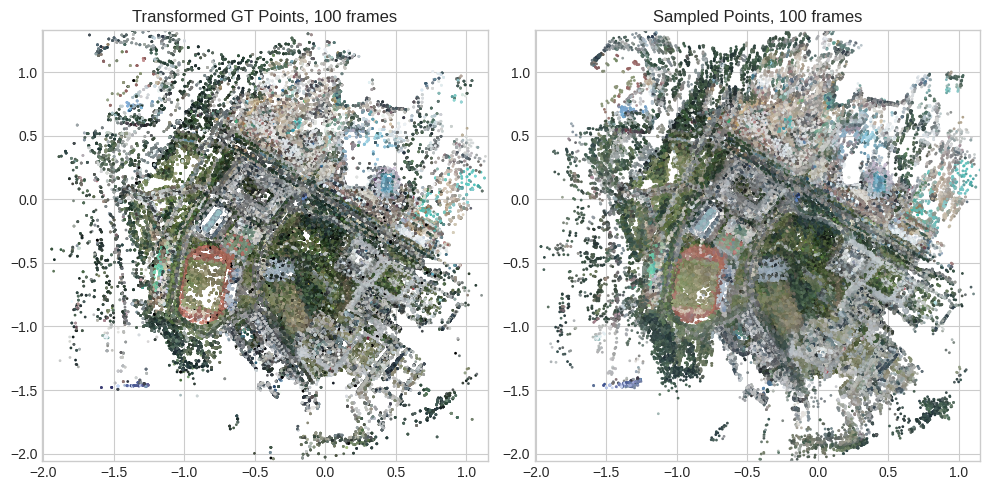

In [ ]:
x_min, x_max = pcd_xyz_sampled_array[:, 0].min(), pcd_xyz_sampled_array[:, 0].max()
y_min, y_max = pcd_xyz_sampled_array[:, 1].min(), pcd_xyz_sampled_array[:, 1].max()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pcd_xyz_gt_array[:, 0], pcd_xyz_gt_array[:, 1], c=pcd_rgb_gt_array, s=1)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f"Transformed GT Points, {total_frame_num} frames")

plt.subplot(1, 2, 2)
plt.scatter(pcd_xyz_sampled_array[:, 0], pcd_xyz_sampled_array[:, 1], c=pcd_rgb_sampled_array, s=1)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f"Sampled Points, {total_frame_num} frames")

plt.tight_layout()